1. 하나은행에서 환율 정보 가져오기
2. 1995-01-03부터 2025-04-08
3. 월-금 datetime 함수
4. selenium으로 날짜 입력 후 환율 조회
5. pd.read_html으로 테이블 데이터 추출
6. mysql에 exchange_rate DB 생성 후 exchange_rate 테이블로 저장
7. dataframe['date'] = date 추가

In [5]:
import pandas as pd
from io import StringIO

import time
import holidays
from datetime import datetime

from general_dbio import *

In [11]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

options = Options()
options.add_experimental_option("detach", True)
options.add_argument('start-maximized')

# 사람인척하기위해서 개발자도구 network에서 user-agent추가, 언어 추가
options.add_argument('Chrome/134.0.0.0')
options.add_argument('lang=ko_KR')

driver = webdriver.Chrome(
    service=Service(ChromeDriverManager().install()),
    options=options
    )
driver.get("https://www.kebhana.com/cont/mall/mall15/mall1501/index.jsp?_menuNo=23100&#35;//HanaBank")

## iframe의 존재 확인--!!

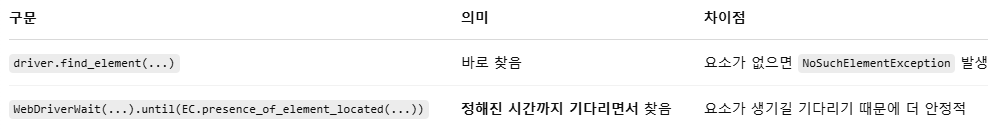

✅ 결론:
* iframe = WebDriverWait(...).until(...) → iframe 변수에 WebElement가 할당됨 ✔️

* 실제로 find_element()와 동일하게 동작함 (단, 타이밍 이슈를 회피)

* 이후에 driver.switch_to.frame(iframe) 쓸 수 있음

#### 프레임이 여러개인 경우
iframes = WebDriverWait(driver, 10).until(
____EC.presence_of_all_elements_located((By.TAG_NAME, 'iframe'))
)

driver.switch_to.frame(iframes[0])  # 첫 번째 프레임으로 이동

In [50]:
print(saveDB.__doc__)


    DB에 저장하는 함수
    df, db_name, table_name을 argument로
    


## 특정 기간을 기준으로 반복문
* pandas의 date_range() 사용

In [12]:
start_date = "1995-01-03"
end_date = "2025-04-08"
columns = ['통화', '현찰_살때_환율', '현찰_살때_spread', '현찰_팔때_환율', '현찰_팔때_spread', '송금_보낼때', '송금_받을때', '외화_수표_팔때', '매매기준율', '환가료율', '미화환산율']

# 한국 공휴일 리스트 가져오기 (1995년~2025년)
kr_holidays = holidays.KR(years=[1995, 2025])

for date in pd.date_range(start=start_date, end=end_date):
    if date.weekday() >= 5 or date in kr_holidays:
        continue

    iframe = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.TAG_NAME, 'iframe'))
    )
    driver.switch_to.frame(iframe)

    date_search_box = driver.find_element(By.CSS_SELECTOR, '#tmpInqStrDt')
    date_search_box.clear()
    date_search_box.send_keys(date.strftime('%Y-%m-%d'))

    search_btn = driver.find_element(By.CSS_SELECTOR, '#HANA_CONTENTS_DIV > div.btnBoxCenter > a')
    search_btn.click()

    exchange_rate_table = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, '#searchContentDiv > div.printdiv > table'))
    ) #.get_attribute('outerHTML') 했어도 됐을 듯!!!

    df = pd.read_html(StringIO(driver.page_source))[1]
    df.columns = columns
    df.insert(0, '날짜', date.strftime('%Y-%m-%d'))
#     display(df)

    saveDB(df, 'hanabank_exchange_rate', 'exchange_rate')

    driver.switch_to.default_content()  # 원래 메인 페이지로 돌아오기
    print(date.strftime('%Y-%m-%d'), ': 저장완료', end='\r')
    time.sleep(5)

In [10]:
driver.quit()